# Baseline model (No skip, no dropout)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_emg_metrics(csv_path: str):
    """
    Reads a CSV metrics file from emg2qwerty logs and generates two plots:
    1) Train and Validation Loss vs. Epoch
    2) Train and Validation CER vs. Epoch

    Args:
        csv_path (str): File path to the CSV metrics log.
    """
    # 1) Load the CSV file
    df = pd.read_csv(csv_path)

    # 2) Convert 'epoch' column to numeric and filter out rows without valid epochs
    df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce')
    df = df[df['epoch'].notnull()]

    # 3) Convert relevant metrics to numeric
    for col in ["train/loss", "train/CER", "val/loss", "val/CER"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # 4) Group by epoch and take the last non-null value for each metric
    grouped = df.groupby("epoch").agg({
        "train/loss": "last",
        "train/CER": "last",
        "val/loss": "last",
        "val/CER": "last"
    }).reset_index()

    # 5) Sort by epoch in case rows are out of order
    grouped = grouped.sort_values("epoch")

    # ---------- Plot 1: Train and Validation Loss vs. Epoch ----------
    plt.figure(figsize=(10, 6))
    plt.plot(grouped["epoch"], grouped["train/loss"], marker='o', linestyle='-', label="Train Loss")
    plt.plot(grouped["epoch"], grouped["val/loss"], marker='s', linestyle='--', label="Val Loss")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Train and Validation Loss vs. Epoch", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # ---------- Plot 2: Train and Validation CER vs. Epoch ----------
    plt.figure(figsize=(10, 6))
    plt.plot(grouped["epoch"], grouped["train/CER"], marker='o', linestyle='-', label="Train CER")
    plt.plot(grouped["epoch"], grouped["val/CER"], marker='s', linestyle='--', label="Val CER")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("CER", fontsize=12)
    plt.title("Train and Validation CER vs. Epoch", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




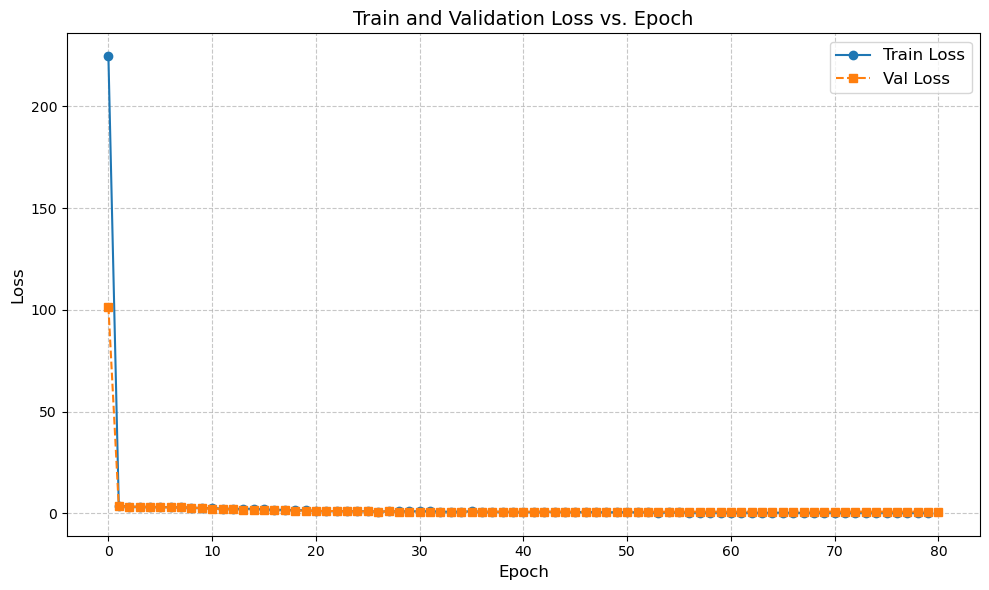

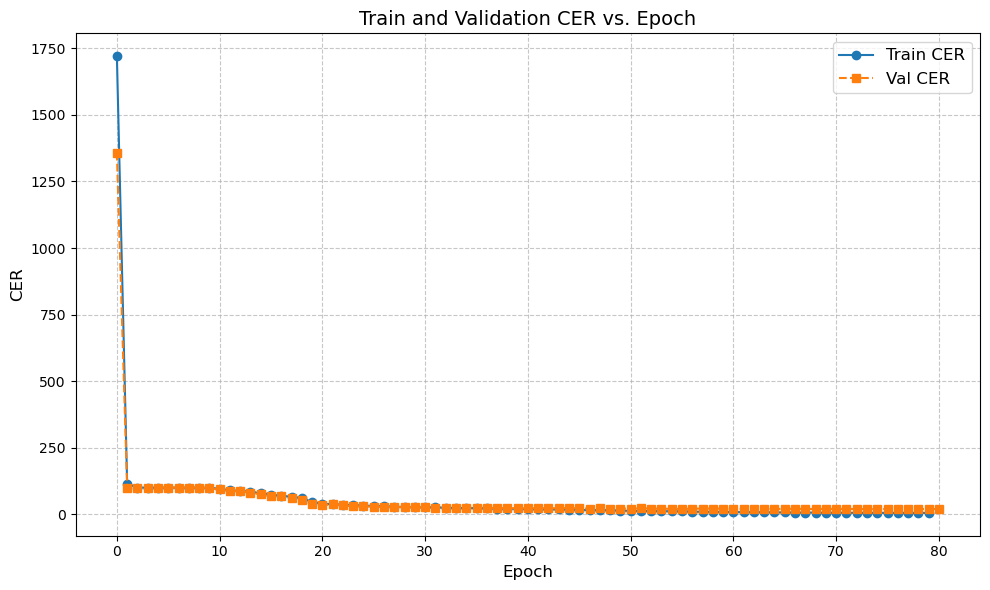

In [3]:
csv_path = "logs/2025-03-02/17-39-57/training_logs/version_0/metrics.csv"
plot_emg_metrics(csv_path)


# Dropout added

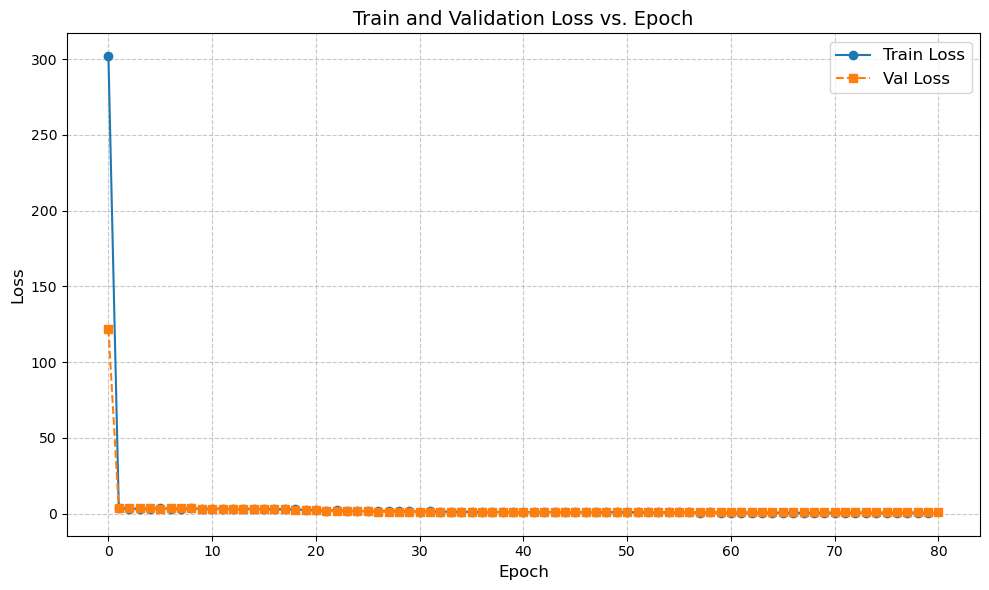

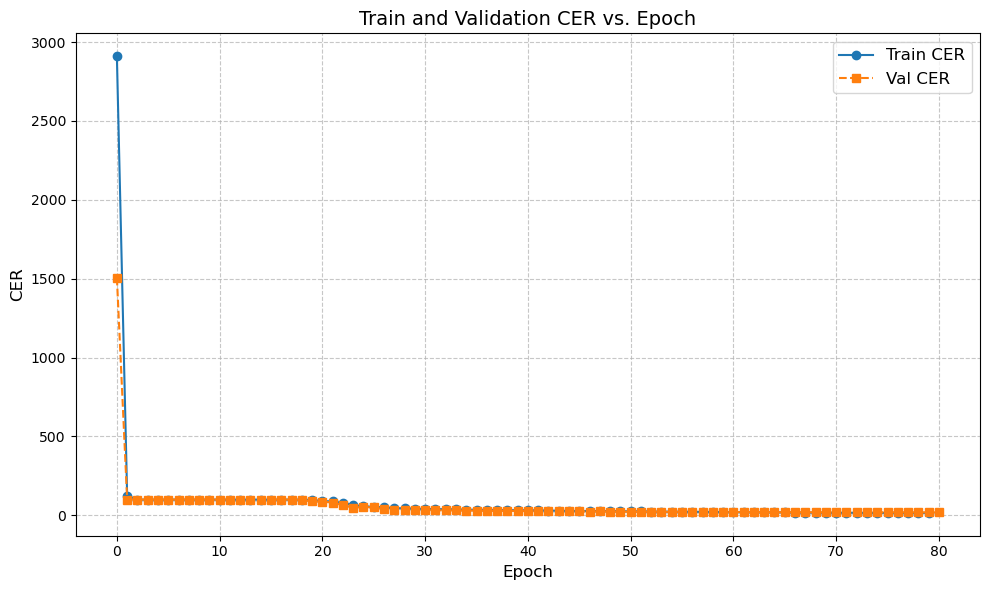

In [12]:
csv_path = "logs/2025-03-02/16-29-02/training_logs/version_0/metrics.csv"
plot_emg_metrics(csv_path)

# Dropout added, skip added

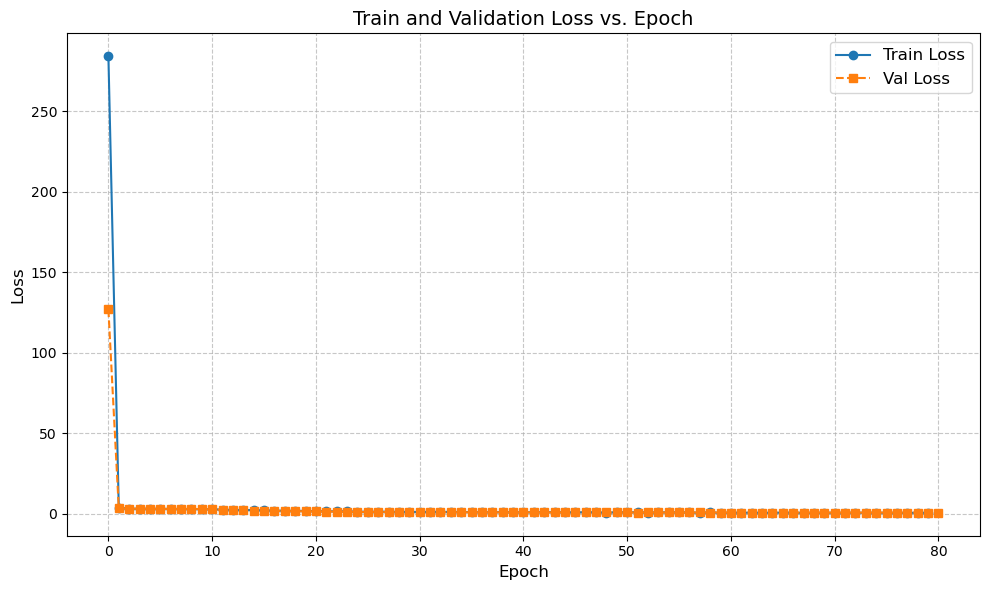

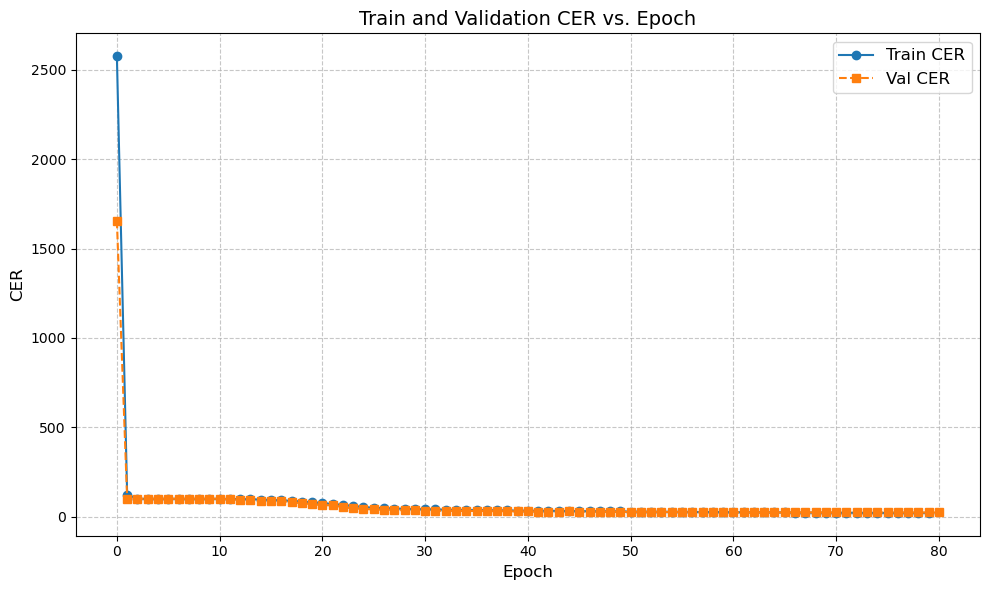

In [14]:
csv_path = "logs/2025-03-02/18-54-04/training_logs/version_0/metrics.csv"
plot_emg_metrics(csv_path)

# Baseline + skip

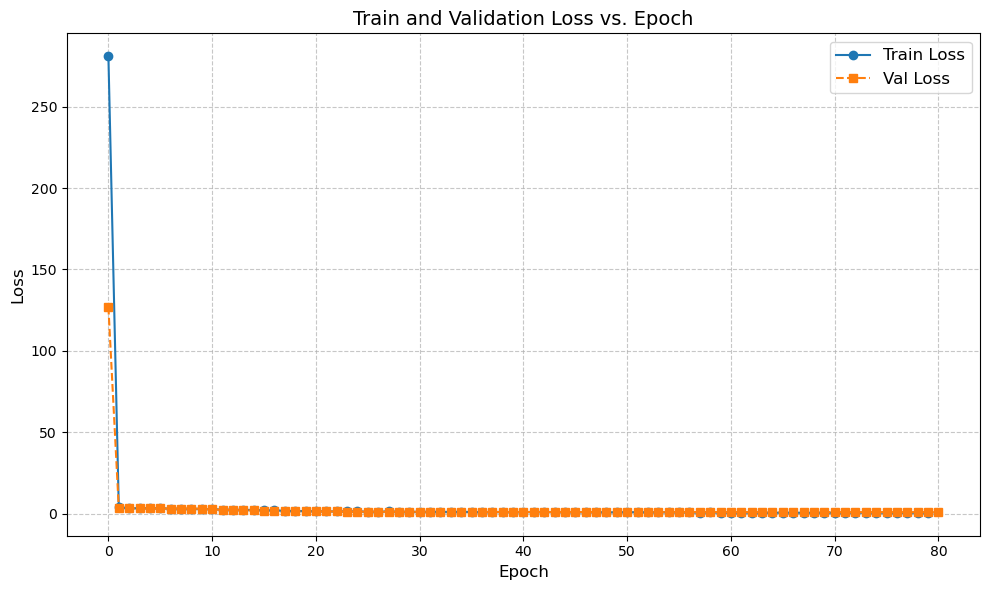

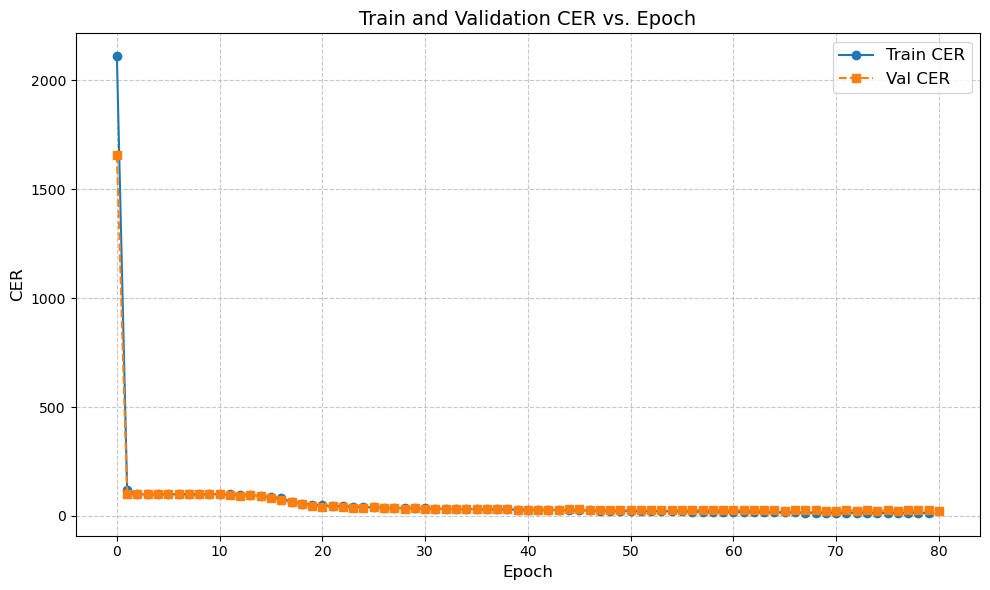

In [15]:
csv_path = "logs/2025-03-02/19-44-17/training_logs/version_0/metrics.csv"
plot_emg_metrics(csv_path)

In [23]:
import subprocess
import re

def extract_metrics(output: str) -> dict:
    """
    Extracts test/loss and test/CER from the output text using regular expressions.
    Assumes that the output contains lines like:
      test/loss: <value>
      test/CER: <value>
    Returns a dictionary with keys "test/loss" and "test/CER".
    """
    metrics = {}
    # Regex patterns to extract the value after test/loss and test/CER (allow decimals)
    loss_pattern = r"(?:['\"]?test/loss['\"]?\s*:\s*)([0-9]+(?:\.[0-9]+)?)"
    cer_pattern  = r"(?:['\"]?test/CER['\"]?\s*:\s*)([0-9]+(?:\.[0-9]+)?)"
    
    loss_match = re.search(loss_pattern, output)
    cer_match  = re.search(cer_pattern, output)
    
    if loss_match:
        try:
            metrics["test/loss"] = float(loss_match.group(1))
        except Exception as e:
            metrics["test/loss"] = "N/A"
    else:
        metrics["test/loss"] = "N/A"
    
    if cer_match:
        try:
            metrics["test/CER"] = float(cer_match.group(1))
        except Exception as e:
            metrics["test/CER"] = "N/A"
    else:
        metrics["test/CER"] = "N/A"
        
    return metrics

def test_and_tabulate_models():
    """
    Runs the emg2qwerty.train script with train=false and appropriate model override and checkpoint,
    then extracts 'test/loss' and 'test/CER' from the output and prints a simple table.
    """
    # Mapping: Model Name -> (checkpoint path, model override)
    model_info = {
        "Baseline (TDSConvCTCModule) (skip present)": ("logs/2025-03-02/17-39-57/checkpoints/epoch=73-step=8880.ckpt", "tds_conv_ctc"),
        "Baseline + dropout - skip connections":          ("logs/2025-03-02/16-29-02/checkpoints/epoch=71-step=8640.ckpt", "tds_conv_ctc_with_dropout_no_skip"),
        "Baseline (skip present) + dropout":   ("logs/2025-03-02/18-54-04/checkpoints/epoch=77-step=9360.ckpt", "tds_conv_ctc_with_dropout_with_skip"),
        #"Baseline + skip":             ("logs/2025-03-02/19-44-17/checkpoints/epoch=72-step=8760.ckpt", "tds_conv_ctc_no_dropout_with_skip"),
    }
    
    results = []
    
    for model_name, (ckpt_path, model_override) in model_info.items():
        print(f"\n--- Testing: {model_name} ---")
        # Build the command.
        # Note: Use 'train=false' (all lowercase) and wrap the checkpoint path in quotes.
        cmd = [
            "python", "-m", "emg2qwerty.train",
            "train=false",
            f'checkpoint="{ckpt_path}"',
            f"model={model_override}"
        ]
        ret = subprocess.run(cmd, capture_output=True, text=True)
        print(ret.stdout)
        if ret.stderr.strip():
            print("Errors/Warnings:\n", ret.stderr)
        
        # Extract metrics using regex (from the entire output)
        metrics = extract_metrics(ret.stdout)
        results.append((model_name, metrics))
    
    # Tabulate the results for test/loss and test/CER
    print("\n===== Final Test Metrics =====")
    columns = ["test/loss", "test/CER"]
    header = f"{'Model':40s}" + "".join([f"{col:>15s}" for col in columns])
    print(header)
    
    for name, metrics in results:
        row = f"{name:40s}"
        for col in columns:
            val = metrics.get(col, "N/A")
            if isinstance(val, float):
                row += f"{val:15.3f}"
            else:
                row += f"{str(val):>15s}"
        print(row)

# Run the function
test_and_tabulate_models()



--- Testing: Baseline (TDSConvCTCModule) (skip present) ---
[2025-03-03 00:43:04,329][__main__][INFO] - 
Config:
user: single_user
dataset:
  train:
  - user: 89335547
    session: 2021-06-03-1622765527-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-02-1622681518-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-04-1622863166-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-07-22-1627003020-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-07-21-1626916256-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-07-22-1627004019-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-05-1622885888-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-02-162267996

# LSTM added

## 80 epochs

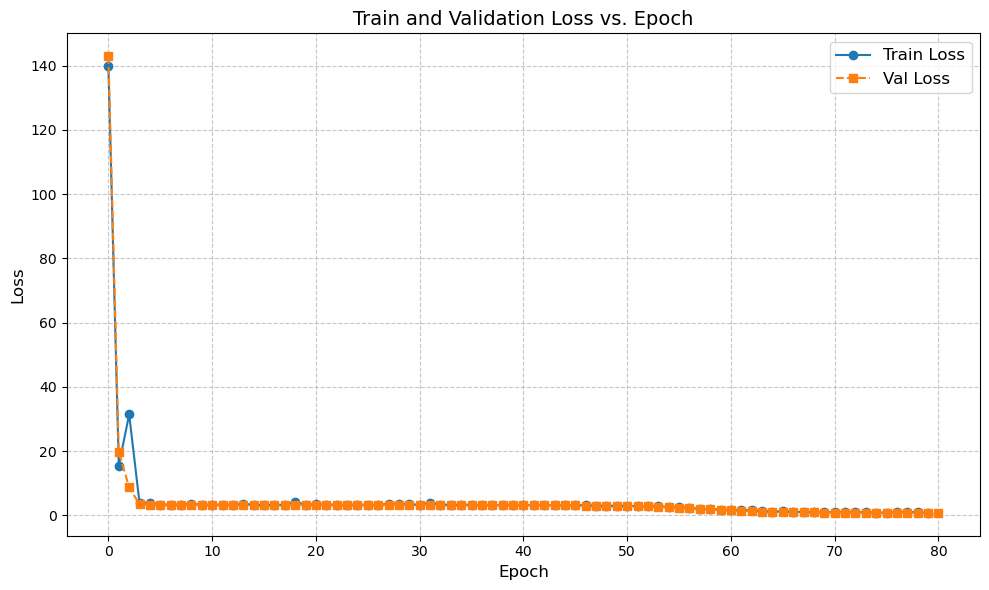

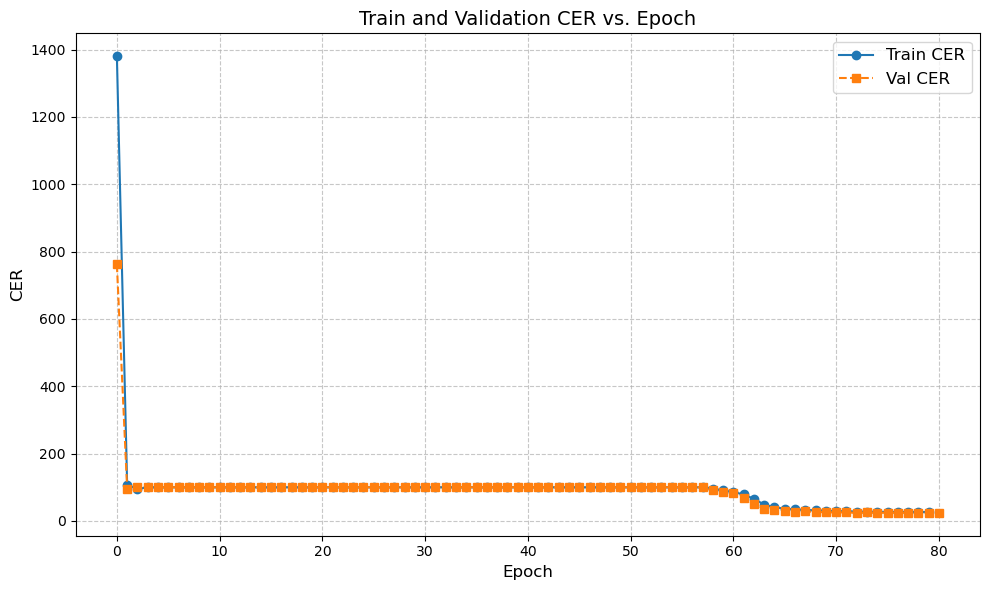

In [24]:
csv_path = "logs/2025-03-03/01-03-27/training_logs/version_0/metrics.csv"
plot_emg_metrics(csv_path)

## 150 epochs

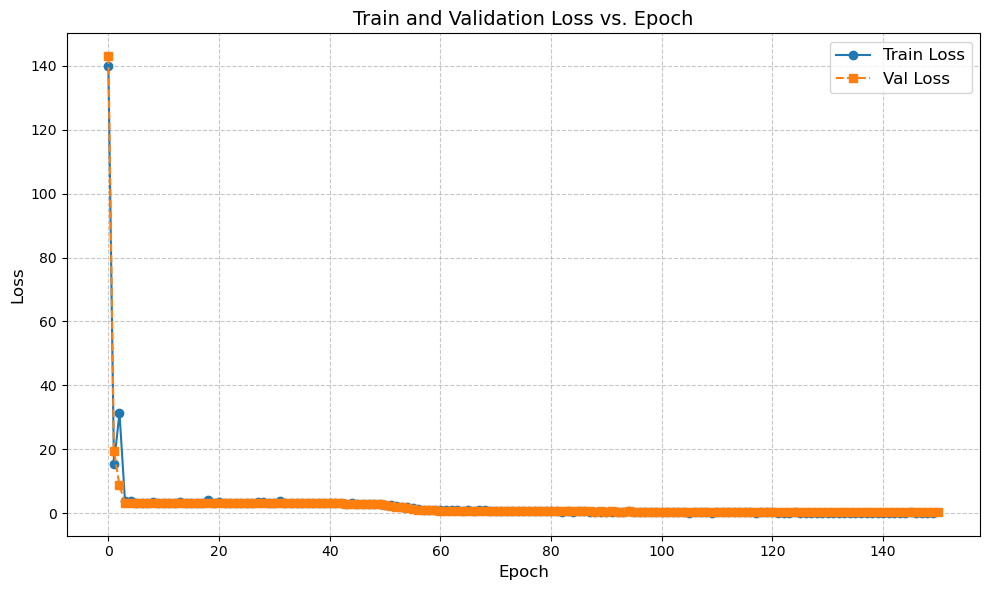

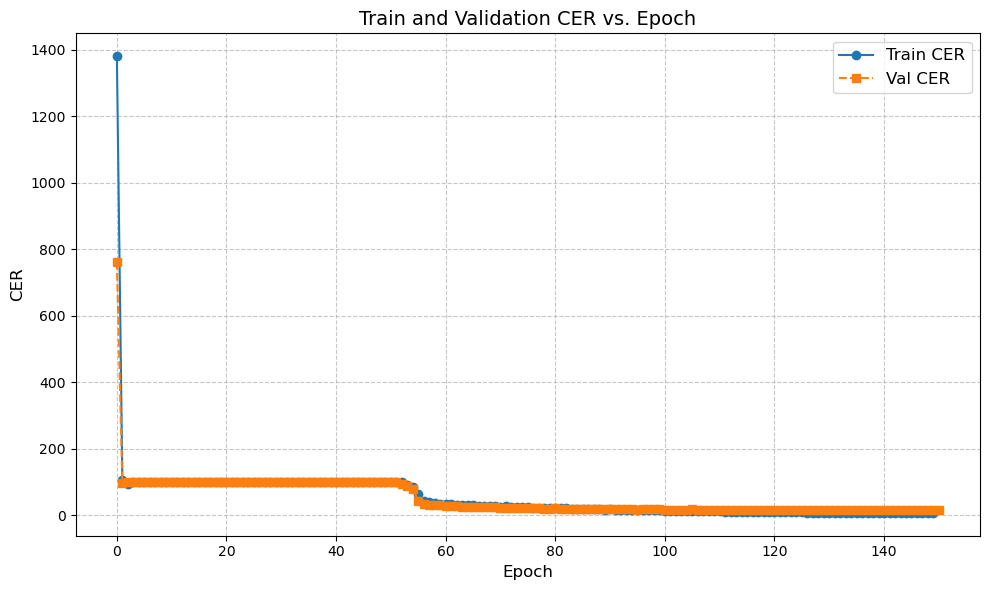

In [5]:
csv_path = "logs/2025-03-03/02-05-52/training_logs/version_0/metrics.csv"
plot_emg_metrics(csv_path)

## MLP features increased to 480 from 384, dropout increased to 0.3 and epochs increased to 400

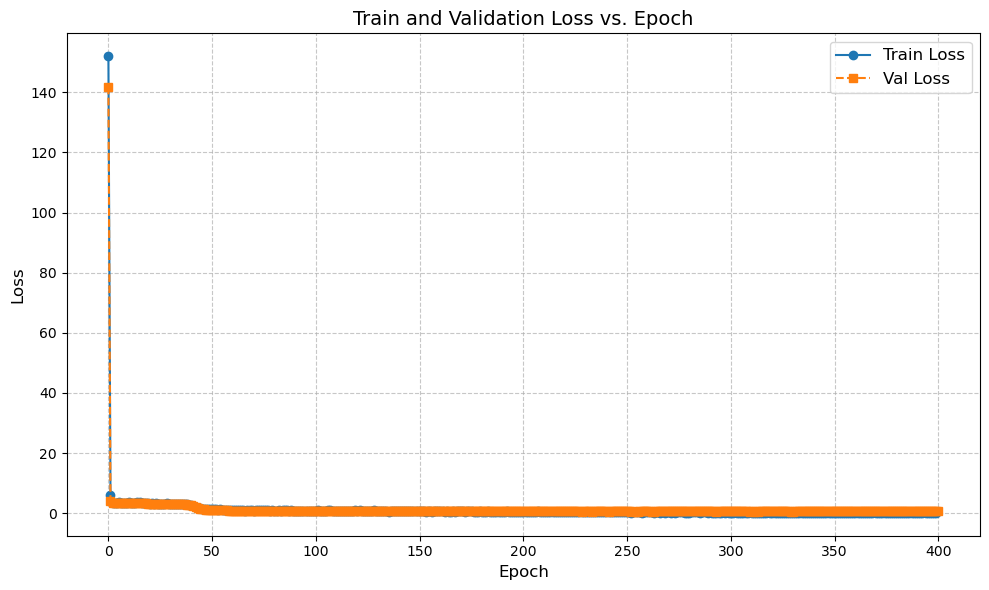

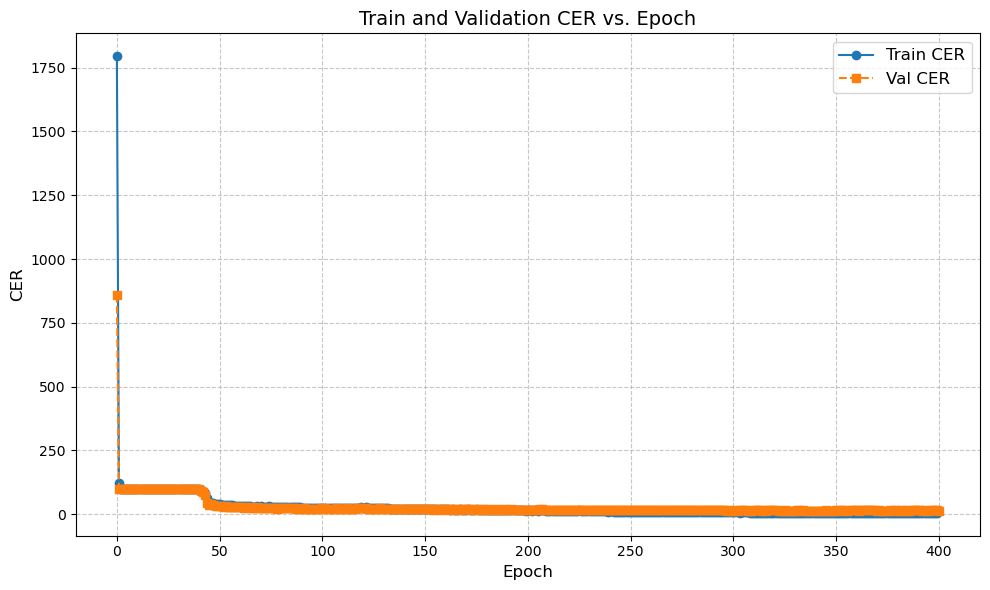

In [6]:
csv_path = "logs/2025-03-04/03-33-57/training_logs/version_0/metrics.csv"
plot_emg_metrics(csv_path)

In [8]:
import subprocess
import re
ckpt_path = 'logs/2025-03-04/03-33-57/checkpoints/epoch=341-step=41040.ckpt'
model_override = 'tds_bilstm_ctc'
cmd = [
            "python", "-m", "emg2qwerty.train",
            "train=false",
            f'checkpoint="{ckpt_path}"',
            f"model={model_override}"
        ]
ret = subprocess.run(cmd, capture_output=True, text=True)
print(ret.stdout)

[2025-03-04 15:23:45,491][__main__][INFO] - 
Config:
user: single_user
dataset:
  train:
  - user: 89335547
    session: 2021-06-03-1622765527-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-02-1622681518-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-04-1622863166-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-07-22-1627003020-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-07-21-1626916256-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-07-22-1627004019-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-05-1622885888-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f
  - user: 89335547
    session: 2021-06-02-1622679967-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f